In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
#importing necessary packages:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

# Variable Treating

In [55]:
df = pd.read_excel('/content/drive/MyDrive/Artefact/database.xlsx')

In [56]:
df.head()

,ID,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL
0,1,SECUNDÁRIO,GERENTE,INTERIOR,30,1,4279.5
1,2,SUPERIOR,AUXILIAR,INTERIOR,32,4,4575.4
2,3,SECUNDÁRIO,AUXILIAR,CAPITAL,33,2,4735.6
3,4,SUPERIOR,GERENTE,INTERIOR,34,3,4863.1
4,5,SECUNDÁRIO,GERENTE,INTERIOR,36,1,5355.8


In [57]:
df.dtypes

ID                  int64
EDUCAÇÃO           object
CARGO              object
LOCAL              object
IDADE               int64
TEMPOCASA           int64
SALARIO_MENSAL    float64
dtype: object

In [58]:
#dropping the ID feature:
df.drop('ID', axis=1, inplace=True)

In [59]:
df.describe()

,IDADE,TEMPOCASA,SALARIO_MENSAL
count,80.000000,80.000000,80.000000
mean,49.750000,10.887500,5777.622500
std,9.594962,7.401665,1138.187752
min,30.000000,0.000000,4186.600000
25%,43.750000,3.750000,4894.300000
50%,49.000000,12.500000,5673.450000
75%,56.000000,17.000000,6306.300000
max,72.000000,25.000000,12465.800000


In [60]:
df.head()

,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL
0,SECUNDÁRIO,GERENTE,INTERIOR,30,1,4279.5
1,SUPERIOR,AUXILIAR,INTERIOR,32,4,4575.4
2,SECUNDÁRIO,AUXILIAR,CAPITAL,33,2,4735.6
3,SUPERIOR,GERENTE,INTERIOR,34,3,4863.1
4,SECUNDÁRIO,GERENTE,INTERIOR,36,1,5355.8


In [61]:
#Get dummies for "EDUCAÇÃO" and "CARGO"

edu_dummies = pd.get_dummies(df['EDUCAÇÃO'], prefix='EDUCAÇÃO', drop_first=True)
local_dummies = pd.get_dummies(df['LOCAL'], prefix='LOCAL', drop_first=True)

# Concatenar os dummies ao DataFrame original
df = pd.concat([df, edu_dummies, local_dummies], axis=1)

df.head()

,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL,EDUCAÇÃO_SUPERIOR,LOCAL_INTERIOR
0,SECUNDÁRIO,GERENTE,INTERIOR,30,1,4279.5,0,1
1,SUPERIOR,AUXILIAR,INTERIOR,32,4,4575.4,1,1
2,SECUNDÁRIO,AUXILIAR,CAPITAL,33,2,4735.6,0,0
3,SUPERIOR,GERENTE,INTERIOR,34,3,4863.1,1,1
4,SECUNDÁRIO,GERENTE,INTERIOR,36,1,5355.8,0,1


In [62]:
#Drop "EDUCAÇÃO" and "CARGO"

df.drop('EDUCAÇÃO', axis=1, inplace=True)
df.drop('CARGO', axis=1, inplace=True)
df.drop('LOCAL', axis=1, inplace=True)
df.head()

,IDADE,TEMPOCASA,SALARIO_MENSAL,EDUCAÇÃO_SUPERIOR,LOCAL_INTERIOR
0,30,1,4279.5,0,1
1,32,4,4575.4,1,1
2,33,2,4735.6,0,0
3,34,3,4863.1,1,1
4,36,1,5355.8,0,1


In [63]:
#reindexing the features:
#defining the new order:
new_order = ['EDUCAÇÃO_SUPERIOR', 'LOCAL_INTERIOR', 'IDADE', 'TEMPOCASA', 'SALARIO_MENSAL']

# reorganize columns:
df = df.reindex(columns=new_order)

df.head()

,EDUCAÇÃO_SUPERIOR,LOCAL_INTERIOR,IDADE,TEMPOCASA,SALARIO_MENSAL
0,0,1,30,1,4279.5
1,1,1,32,4,4575.4
2,0,0,33,2,4735.6
3,1,1,34,3,4863.1
4,0,1,36,1,5355.8


In [64]:
# Changing 'EDUCAÇÃO_SUPERIOR' to 'EDU_SUP' to avoid problems:
df.rename(columns={'EDUCAÇÃO_SUPERIOR': 'EDU_SUP'}, inplace=True)

In [65]:
df.head()

,EDU_SUP,LOCAL_INTERIOR,IDADE,TEMPOCASA,SALARIO_MENSAL
0,0,1,30,1,4279.5
1,1,1,32,4,4575.4
2,0,0,33,2,4735.6
3,1,1,34,3,4863.1
4,0,1,36,1,5355.8


# Exploratory Analysis

In [66]:
df.groupby(['LOCAL_INTERIOR'])['SALARIO_MENSAL'].describe()

,count,mean,std,min,25%,50%,75%,max
LOCAL_INTERIOR,,,,,,,,
0,45.0,6095.542222,1300.428122,4434.6,5131.2,6051.3,6583.9,12465.8
1,35.0,5368.868571,718.191711,4186.6,4878.7,5254.4,5917.7,6796.9


<function matplotlib.pyplot.show(close=None, block=None)>

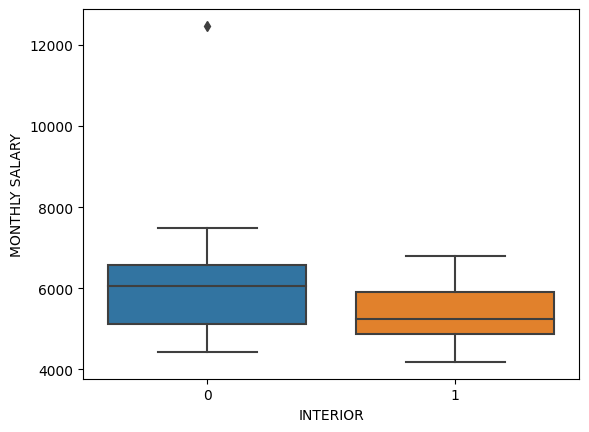

In [67]:
sns.boxplot(x='LOCAL_INTERIOR', y = 'SALARIO_MENSAL', data = df)
plt.xlabel('INTERIOR')
plt.ylabel('MONTHLY SALARY')
plt.show

On average, as well as in terms of median salary, it is evident that employees residing in the capital receive higher salaries compared to individuals in other cities.

It is important to note that the ordinary least squares (OLS) assumption assumes the absence of outliers in the residuals. The presence of outliers may potentially impact the model's accuracy. However, since there is only a single outlier that falls outside the expected range, we will proceed with the modeling process. In the final analysis, we can assess the impact of this outlier by considering its removal and evaluating the resulting effects on the model.

# First regression model


In this section, our primary objective is to perform a regression analysis between the 'LOCAL_INTERIOR' variable and the 'SALARIO_MENSAL' variable to examine their relationship and interaction.

In [68]:
mod1 = smf.ols(formula = 'SALARIO_MENSAL ~ LOCAL_INTERIOR', data = df)

In [69]:
res=mod1.fit()

In [70]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         SALARIO_MENSAL   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     8.819
Date:                Fri, 02 Jun 2023   Prob (F-statistic):            0.00396
Time:                        13:54:06   Log-Likelihood:                -671.70
No. Observations:                  80   AIC:                             1347.
Df Residuals:                      78   BIC:                             1352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6095.5422    161.850     37.

**Regarding the results:**

- The obtained R-squared value is significantly low, indicating that the salary cannot be accurately predicted solely based on the location feature.

- The Prob(F-statistic) demonstrates that the model performs better than a model without a dependent variable.

- Furthermore, the variable 'LOCAL_INTERIOR' exhibits a low p-value (0.004), suggesting that it contributes significantly to the prediction of the 'SALARIOMENSAL' variable.

Considering these observations, it is appropriate to proceed with a second regression analysis, this time incorporating multiple variables.


# Multivariable Linear Regression

For the Multivariable Linear Regression we will be using the OLS (Ordinary Least Squares), which is a linear regression model that minimizes the sum of squared differences between the observed and predicted values to estimate the relationship between a dependent variable and one or more independent variables.

But, to perfectly perform the OLS, we need to follow the 8 premisses:

- **Linearity:** The relationship between the independent variables and the dependent variable should be linear. If this assumption is violated, it may lead to biased and unreliable results.
-  **Zero mean of the error term:** The error term, or residuals, should have a population mean of zero. This implies that, on average, the model's predictions should be accurate.
-  **No correlation between independent variables and the error term (exogeneity):** The independent variables should not be systematically related to the error term. If there is a correlation, it can introduce bias and affect the estimated coefficients.
-  **No autocorrelation in the error terms:** The error terms should be independent and not exhibit any systematic patterns or correlations over time or across observations. Autocorrelation can lead to inefficient and inconsistent coefficient estimates.
-  **Homoscedasticity:** The error terms should have constant variance across all levels of the independent variables. Violation of this assumption, called heteroscedasticity, can affect the efficiency of the coefficient estimates and invalidate statistical tests.
- **No multicollinearity:** The independent variables should not be highly correlated with each other. High multicollinearity can make it difficult to determine the individual effects of each variable and can lead to unstable coefficient estimates.
- **Normal distribution of the error term:** The error term should follow a normal distribution.
- **No outliers in the residuals:** The error terms should not contain extreme or influential observations that deviate substantially from the overall pattern. Outliers can distort the model's results and affect the estimated coefficients.

**Checking for multicollinearity**

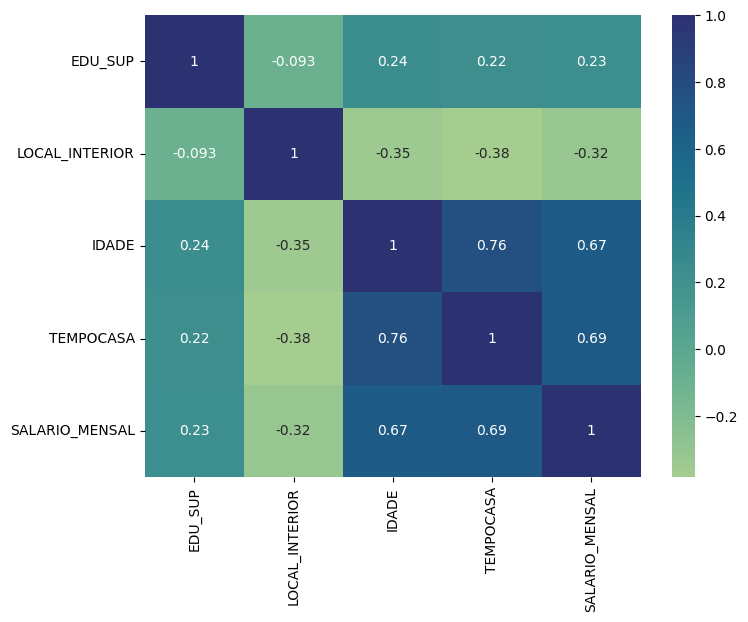

In [71]:
corr=df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(),annot=True, cmap="crest")
plt.show()

In [72]:
#Checking for VIF:
X = df[['EDU_SUP','LOCAL_INTERIOR', 'IDADE','TEMPOCASA']]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

vif

,Variable,VIF
0,EDU_SUP,5.524962
1,LOCAL_INTERIOR,1.901649
2,IDADE,12.498800
3,TEMPOCASA,6.054795


Based on the Variance Inflation Factor (VIF) values exceeding 5 for both the "IDADE" (age) and "TEMPOCASA" (tenure) variables, it is necessary to eliminate one of these variables from the analysis to address multicollinearity. Considering that "IDADE" exhibits a lower correlation with "SALARIO_MENSAL", it was decided to exclude age from the analysis.

The decision to remove age was based on business knowledge and the understanding that tenure and salary tend to have a stronger correlation in organizations. Typically, companies offer salary increases to employees with longer tenure as a retention strategy. Therefore, it is reasonable to focus on retaining the "TEMPOCASA" variable, representing tenure, as it captures the temporal aspect related to salary.

By removing age and retaining tenure, we can reduce multicollinearity and enhance the interpretability and stability of the model. It allows us to analyze the specific effect of tenure on salary without the confounding influence of age.

In [73]:
mod2 = smf.ols(formula = 'SALARIO_MENSAL ~ LOCAL_INTERIOR + TEMPOCASA + EDU_SUP', data = df) #3 variables, removing IDADE

In [74]:
res2 = mod2.fit()

# Checking the Homocedasticity

[Text(0.5, 0, 'Fited'), Text(0, 0.5, 'Residuals')]

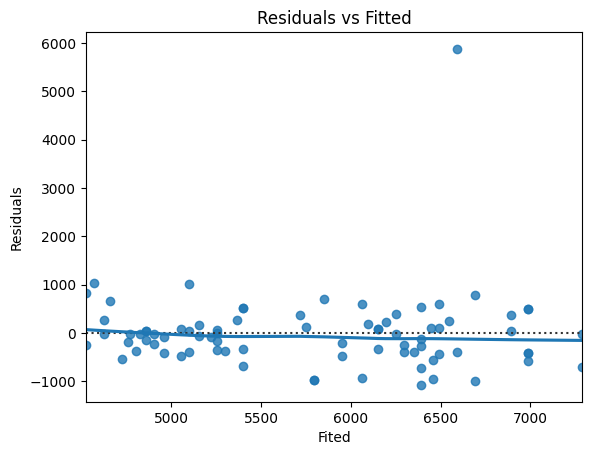

In [75]:
y = df['SALARIO_MENSAL']
fig, ax = plt.subplots(1,1)

sns.residplot(x=res2.fittedvalues, y=res2.resid, lowess = True)
ax.title.set_text('Residuals vs Fitted')
ax.set(xlabel = 'Fited', ylabel = 'Residuals')

In [76]:
res2.resid.mean()

-9.094947017729282e-13

Based on the data and the resid mean there is no observable trend, indicating that we have homoscedasticity.

# Checking the the Resid vs Independent variable

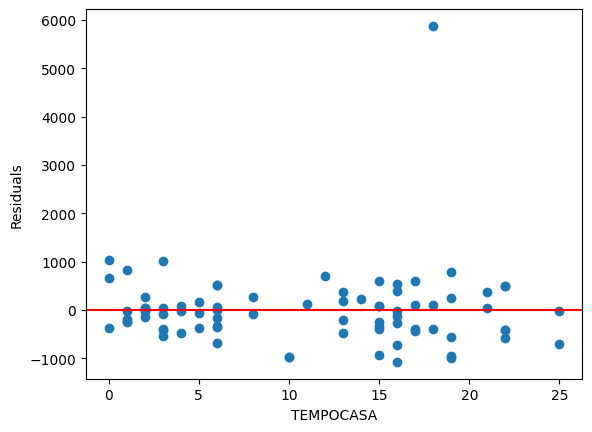

In [77]:
df_resid = df.copy()
df_resid["resid"] = res2.resid

plt.scatter(df_resid["TEMPOCASA"], df_resid["resid"])
plt.axhline(0, color = 'red')
plt.xlabel('TEMPOCASA');
plt.ylabel('Residuals');

Since there is no correlation between the independent variable and the resid, the premise is valid.

## Checking for Resid Autocorrelation 

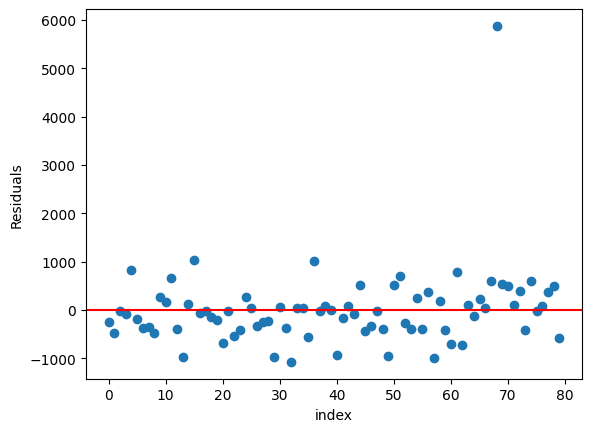

In [78]:
df_auto = res2.resid.reset_index().rename(columns = {0:"resid"})

plt.scatter(df_auto["index"], df_auto["resid"])
plt.axhline(0, color = 'red')
plt.xlabel('index');
plt.ylabel('Residuals');


In [79]:
durbin_watson(res2.resid)

1.785570525294366

Since there is no correlation between the resids and the Durbin-Watson value is between 1 and 3, the premise is valid.

## Checking if resids has a normal distribution

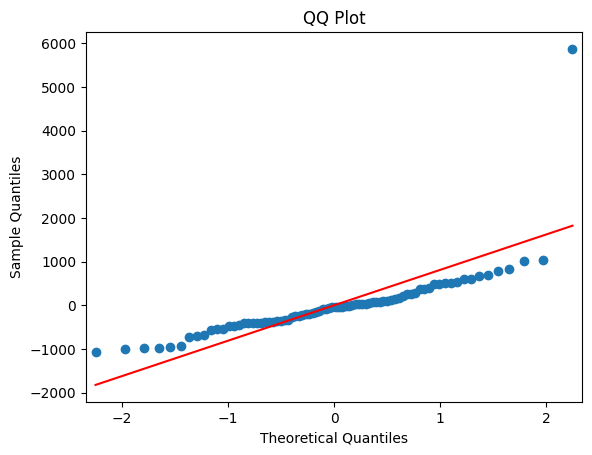

In [80]:
fig, ax = plt.subplots(1,1)
sm.ProbPlot(res2.resid).qqplot(line='s',ax=ax)
ax.title.set_text('QQ Plot')

(array([ 6.,  1.,  3., 12.,  9.,  8., 18.,  6.,  3.,  7.,  4.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-1076.45474399,  -902.69229481,  -728.92984563,  -555.16739645,
         -381.40494727,  -207.64249809,   -33.8800489 ,   139.88240028,
          313.64484946,   487.40729864,   661.16974782,   834.932197  ,
         1008.69464618,  1182.45709536,  1356.21954454,  1529.98199373,
         1703.74444291,  1877.50689209,  2051.26934127,  2225.03179045,
         2398.79423963,  2572.55668881,  2746.31913799,  2920.08158718,
         3093.84403636,  3267.60648554,  3441.36893472,  3615.1313839 ,
         3788.89383308,  3962.65628226,  4136.41873144,  4310.18118062,
         4483.94362981,  4657.70607899,  4831.46852817,  5005.23097735,
         5178.99342653,  5352.75587571,  5526.51832489,  5700.28077407,
         5874.04322326]),
 <BarContainer objec

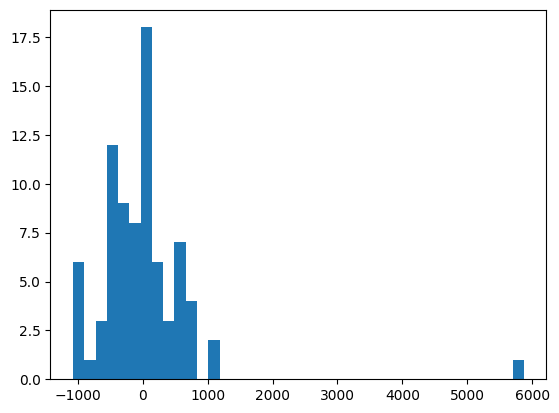

In [81]:
plt.hist(res2.resid, bins =40)

It doesn't look like a normal distribution, let's check the tests given by the summary.


In [82]:
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:         SALARIO_MENSAL   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     23.82
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           5.73e-11
Time:                        13:54:30   Log-Likelihood:                -649.48
No. Observations:                  80   AIC:                             1307.
Df Residuals:                      76   BIC:                             1316.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4567.3894    278.334     16.

**Omnibus Test:**

The Omnibus test evaluates the normality assumption of the residuals.


The Omnibus test statistic is reported as 116.598, and the associated p-value (Prob(Omnibus)) is 0.000.
With a p-value less than 0.05, there is significant evidence to reject the null hypothesis of normality.
This suggests that the residuals may deviate significantly from a normal distribution.

**Durbin-Watson Statistic:**
The Durbin-Watson statistic tests for autocorrelation in the residuals.
In this case, the Durbin-Watson statistic is reported as 1.786.
Since it is between 1 and 3, we will assume that there is no correlation between the residuals

**Jarque-Bera Test:**

The Jarque-Bera test examines the normality assumption of the residuals.
The Jarque-Bera statistic is reported as 3608.169, and the associated p-value (Prob(JB)) is 0.00.
With a p-value less than 0.05, there is significant evidence to reject the null hypothesis of normality.
This reinforces the observation that the residuals may not follow a normal distribution.

**Skewness and Kurtosis:**

Skewness measures the asymmetry of the residuals' distribution.
In this case, the skewness is reported as 4.65, indicating a substantial right skew.
Kurtosis measures the heaviness of the tails of the residuals' distribution.
The reported kurtosis is 34.321, indicating extremely heavy tails compared to a normal distribution.

**Condition Number (Cond. No.)**:

The condition number measures the sensitivity of the regression coefficients to changes in the data.
A higher condition number suggests potential multicollinearity issues.
In this case, the reported condition number is 34,55, which does not raise concerns about severe multicollinearity.

**We do not have a valid OLS regression. Wee need to improve the model.**

# Removing the outlier

After removing the outlier, which corresponds to a Director who is 60 years old and has been with the company for 18 years, we can reevaluate the regression results. This particular data point can be considered an exceptional case due to the individual's extensive experience and senior role within the company. By removing this outlier, we can assess the results without the influence of this extreme observation. Let's examine the revised results:

In [83]:
# Find the index of the row with the maximum value in the "SALARIO_MENSAL" column
max_salary_index = df['SALARIO_MENSAL'].idxmax()

# Remove the row with the maximum value from the DataFrame
df = df.drop(max_salary_index)

<function matplotlib.pyplot.show(close=None, block=None)>

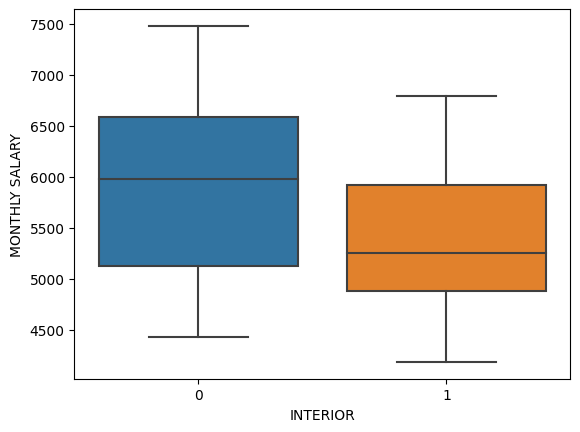

In [84]:
sns.boxplot(x='LOCAL_INTERIOR', y = 'SALARIO_MENSAL', data = df)
plt.xlabel('INTERIOR')
plt.ylabel('MONTHLY SALARY')
plt.show

**Checking for multicollinearity**

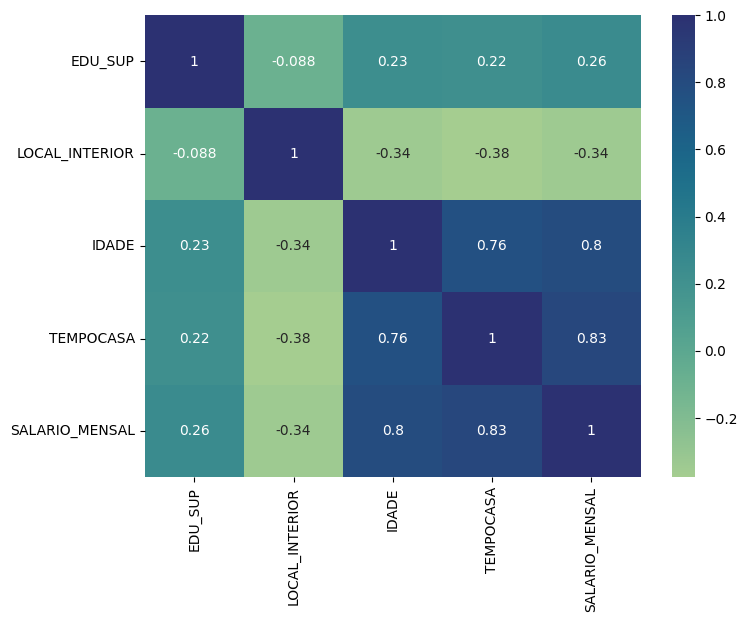

In [85]:
corr=df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(),annot=True, cmap="crest")
plt.show()

In [86]:
mod3 = smf.ols(formula = 'SALARIO_MENSAL ~ LOCAL_INTERIOR + TEMPOCASA + EDU_SUP', data = df) #2 variables, removing IDADE

In [87]:
res3 = mod3.fit()

# Checking the Homocedasticity

[Text(0.5, 0, 'Fited'), Text(0, 0.5, 'Residuals')]

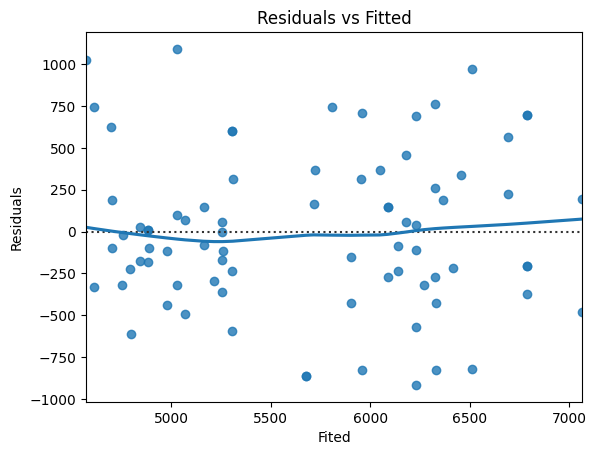

In [88]:
y = df['SALARIO_MENSAL']
fig, ax = plt.subplots(1,1)

sns.residplot(x=res3.fittedvalues, y=res3.resid, lowess = True)
ax.title.set_text('Residuals vs Fitted')
ax.set(xlabel = 'Fited', ylabel = 'Residuals')

In [89]:
res3.resid.mean()

3.637978807091713e-12

# Checking the the Resid vs Independent variable


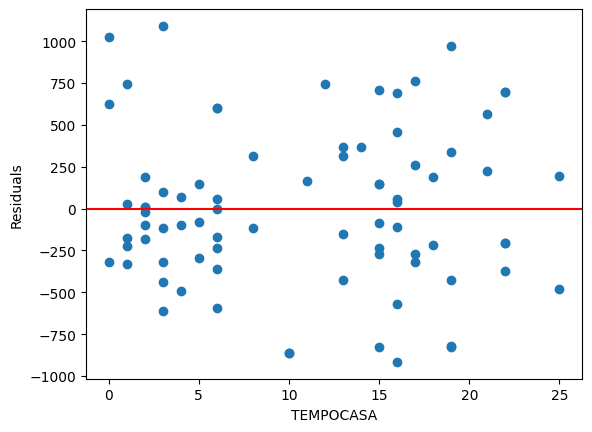

In [90]:
df_resid = df.copy()
df_resid["resid"] = res3.resid

plt.scatter(df_resid["TEMPOCASA"], df_resid["resid"])
plt.axhline(0, color = 'red')
plt.xlabel('TEMPOCASA');
plt.ylabel('Residuals');

## Checking for Resid Autocorrelation 

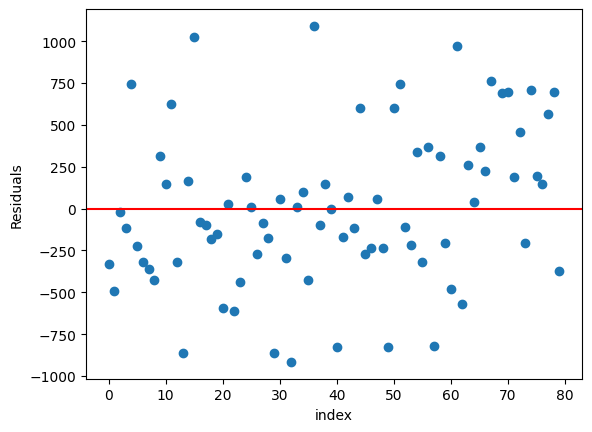

In [91]:
df_auto = res3.resid.reset_index().rename(columns = {0:"resid"})

plt.scatter(df_auto["index"], df_auto["resid"])
plt.axhline(0, color = 'red')
plt.xlabel('index');
plt.ylabel('Residuals');

## Checking if resids has a normal distribution


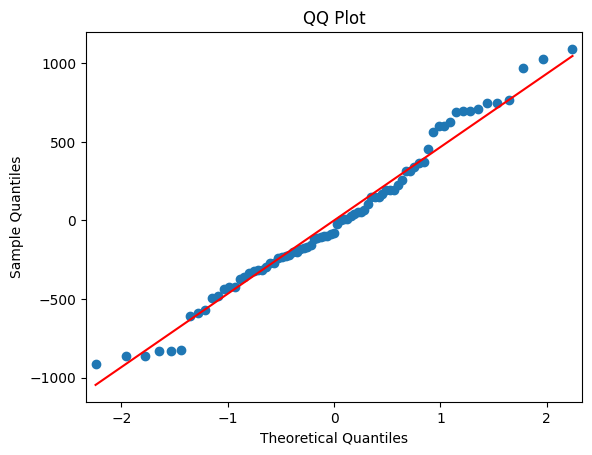

In [92]:
fig, ax = plt.subplots(1,1)
sm.ProbPlot(res3.resid).qqplot(line='s',ax=ax)
ax.title.set_text('QQ Plot')

(array([1., 5., 0., 0., 0., 0., 3., 0., 2., 3., 1., 5., 3., 4., 5., 3., 5.,
        1., 4., 4., 1., 4., 4., 1., 2., 3., 0., 1., 0., 1., 3., 1., 3., 3.,
        0., 0., 0., 1., 1., 1.]),
 array([-915.54206479, -865.37019991, -815.19833502, -765.02647013,
        -714.85460525, -664.68274036, -614.51087547, -564.33901059,
        -514.1671457 , -463.99528081, -413.82341593, -363.65155104,
        -313.47968616, -263.30782127, -213.13595638, -162.9640915 ,
        -112.79222661,  -62.62036172,  -12.44849684,   37.72336805,
          87.89523294,  138.06709782,  188.23896271,  238.4108276 ,
         288.58269248,  338.75455737,  388.92642226,  439.09828714,
         489.27015203,  539.44201691,  589.6138818 ,  639.78574669,
         689.95761157,  740.12947646,  790.30134135,  840.47320623,
         890.64507112,  940.81693601,  990.98880089, 1041.16066578,
        1091.33253067]),
 <BarContainer object of 40 artists>)

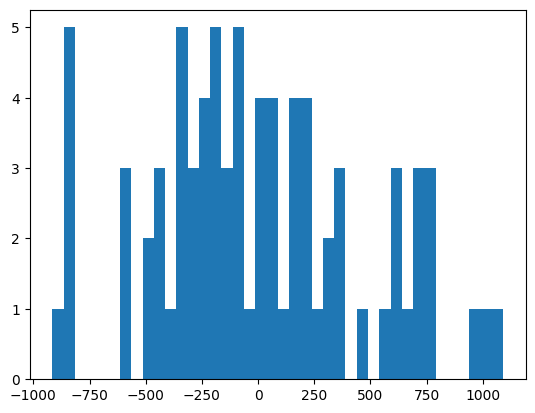

In [93]:
plt.hist(res3.resid, bins=40)

In [94]:
print("\n Results when removing the outlier:\n")
print(res3.summary())



 Results when removing the outlier:

                            OLS Regression Results                            
Dep. Variable:         SALARIO_MENSAL   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     57.82
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           1.83e-19
Time:                        13:56:42   Log-Likelihood:                -597.64
No. Observations:                  79   AIC:                             1203.
Df Residuals:                      75   BIC:                             1213.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Interc

**Omnibus Test:**

The Omnibus test assesses the normality assumption of the residuals.
In this case, the Omnibus test has a statistic of 1.155 and a p-value of 0.561.
Since the p-value (Prob(Omnibus)) is greater than 0.05, there is no evidence to reject the null hypothesis of normality.
This suggests that the residuals may approximately follow a normal distribution.

**Durbin-Watson Statistic:**

The Durbin-Watson statistic tests for autocorrelation in the residuals.
In this case, the Durbin-Watson statistic is reported as 1.985.
A value close to 2 suggests no significant autocorrelation.
Therefore, based on this statistic, there is no strong evidence of autocorrelation in the residuals.

**Jarque-Bera Test:**

The Jarque-Bera test also examines the normality assumption of the residuals.
The Jarque-Bera statistic is reported as 1.23, and the p-value (Prob(JB)) is 0.541.
With a p-value greater than 0.05, there is no significant evidence against the null hypothesis of normality.
This further supports the notion that the residuals may follow a normal distribution.

**Skewness and Kurtosis:**

Skewness measures the asymmetry of the residuals' distribution.
In this case, the skewness is reported as 0.241, indicating a slight right skew.
Kurtosis measures the heaviness of the tails of the residuals' distribution.
The reported kurtosis is 2.624, suggesting a distribution with slightly heavier tails than a normal distribution.

**Condition Number (Cond. No.):**

The condition number measures the sensitivity of the regression coefficients to changes in the data.
A higher condition number indicates potential multicollinearity issues.
In this case, the reported condition number is 48.2, which does not raise concerns about severe multicollinearity.

## Conclusions

After conducting the analysis, it can be concluded that the geographic location of employees does not have a statistically significant impact on their salary, as indicated by the p-value for the variable "LOCAL_INTERIOR" being above the significance level of 0.05.

However, it should be noted that the model without the outlier is more reliable and accurate compared to the model that includes the outlier. The model with all the data does not meet the criteria for an OLS regression, potentially due to the influence of the outlier. By removing the outlier, the model becomes more robust and trustworthy.

Nevertheless, it is important to acknowledge that the model, even without the outlier, may not be highly effective in predicting new salary values. This is evident from the adjusted R-squared value of 0.686, which indicates that only approximately 68.3% of the variation in salaries can be explained by the model. Therefore, while the model can identify relationships between variables, its predictive performance may be limited.

It is recommended to further refine the model by considering additional factors or exploring alternative regression techniques to enhance its predictive power.






